<a href="https://colab.research.google.com/github/del-luna/aiffel/blob/main/TF_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    as_supervised = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteFXSW85/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
def format_image(image, label):
    image = tf.image.resize(image, (SIZE, SIZE))/255.0
    return image, label

num_examples = ds_info.splits['train'].num_examples

BATCH_SIZE = 64
SIZE = 224

train_batches = ds_train.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = ds_test.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [11]:
class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1, flag=True):
        super(BasicBlock, self).__init__()
        self.flag = flag
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3,3),
                                            strides=stride,
                                            padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3,3),
                                            strides=1,
                                            padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        if flag:
            if stride != 1:
                self.shortcut = tf.keras.Sequential()
                self.shortcut.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                        kernel_size=(1,1),
                                                        strides=stride))
                self.shortcut.add(tf.keras.layers.BatchNormalization())
            else:
                self.shortcut = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        if self.flag:
            residual = self.shortcut(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        if self.flag:
            output = tf.nn.relu(tf.keras.layers.add([residual, x]))
        else:
            output = tf.nn.relu(x)
        return output

class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1, flag=True):
        super(BottleNeck, self).__init__()
        self.flag = flag
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=filter_num * 4,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()

        if self.flag:
            self.shortcut = tf.keras.Sequential()
            self.shortcut.add(tf.keras.layers.Conv2D(filters=filter_num * 4,
                                                    kernel_size=(1, 1),
                                                    strides=stride))
            self.shortcut.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, training=None, **kwargs):
        if self.flag:
            residual = self.shortcut(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        if self.flag:
            output = tf.nn.relu(tf.keras.layers.add([residual, x]))
        else:
            output = tf.nn.relu(x)

        return output

def make_basic_block_layer(filter_num, blocks, stride=1, flag=True):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride, flag=flag))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1, flag=flag))

    return res_block


def make_bottleneck_layer(filter_num, blocks, stride=1, flag=True):
    res_block = tf.keras.Sequential()
    res_block.add(BottleNeck(filter_num, stride=stride, flag=flag))

    for _ in range(1, blocks):
        res_block.add(BottleNeck(filter_num, stride=1, flag=flag))

    return res_block

In [12]:
class ResNetTypeI(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeI, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[0])
        self.layer2 = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3 = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


class ResNetTypeII(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeII, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_bottleneck_layer(filter_num=64,
                                            blocks=layer_params[0])
        self.layer2 = make_bottleneck_layer(filter_num=128,
                                            blocks=layer_params[1],
                                            stride=2)
        self.layer3 = make_bottleneck_layer(filter_num=256,
                                            blocks=layer_params[2],
                                            stride=2)
        self.layer4 = make_bottleneck_layer(filter_num=512,
                                            blocks=layer_params[3],
                                            stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output

class ResNetTypeIII(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeIII, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[0], flag=False)
        self.layer2 = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2,  flag=False)
        self.layer3 = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2,  flag=False)
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2,  flag=False)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output

class ResNetTypeIV(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeIV, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[0], flag=False)
        self.layer2 = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2,  flag=False)
        self.layer3 = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2,  flag=False)
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2,  flag=False)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


def resnet_34():
    return ResNetTypeI(layer_params=[3, 4, 6, 3])

def resnet_50():
    return ResNetTypeII(layer_params=[3, 4, 6, 3])

def resnet_34_plain():
    return ResNetTypeIII(layer_params=[3, 4, 6, 3])

def resnet_50_plain():
    return ResNetTypeIV(layer_params=[3, 4, 6, 3])

In [13]:
def get_model(type='resnet34'):
    global model
    if type == 'resnet34':model = resnet_34()
    if type == 'resnet34_plain':model = resnet_34_plain()
    if type == 'resnet50':model = resnet_50()
    if type == 'resnet50_plain':model = resnet_50_plain()

    model.build(input_shape=(None, 224, 224, 3))
    model.summary()
    return model

gpus = tf.config.experimental.list_physical_devices('GPU')
model = get_model('resnet34_plain')

Model: "res_net_type_iii_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_102 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 sequential_15 (Sequential)  (None, 56, 56, 64)        223104    
                                                                 
 sequential_16 (Sequential)  (None, 28, 28, 128)       1111040   
                                                                 
 sequential_17 (Sequential)  (None, 14, 14, 256)

In [14]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adadelta()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [17]:
import math
from tqdm import tqdm
from tqdm import trange

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(y_true=labels, y_pred=predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def valid_step(images, labels):
    predictions = model(images, training=False)
    v_loss = loss_object(labels, predictions)

    valid_loss(v_loss)
    valid_accuracy(labels, predictions)

pbar = trange(30, desc='Valid Loss : 0', leave=True, position=0)
train_acc_list = []
train_loss_list = []
valid_acc_list = []
valid_loss_list = []

# start training
for epoch in pbar:
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    step = 0
    for images, labels in train_batches:
        step += 1
        train_step(images, labels)

    for valid_images, valid_labels in validation_batches:
        valid_step(valid_images, valid_labels)
    pbar.set_description("Valid Loss: %.3f" % valid_loss.result())

    train_acc_list.append(train_accuracy.result())
    train_loss_list.append(train_loss.result())
    valid_acc_list.append(valid_accuracy.result())
    valid_loss_list.append(valid_loss.result())

Valid Loss: 0.648: 100%|██████████| 30/30 [25:28<00:00, 50.95s/it]


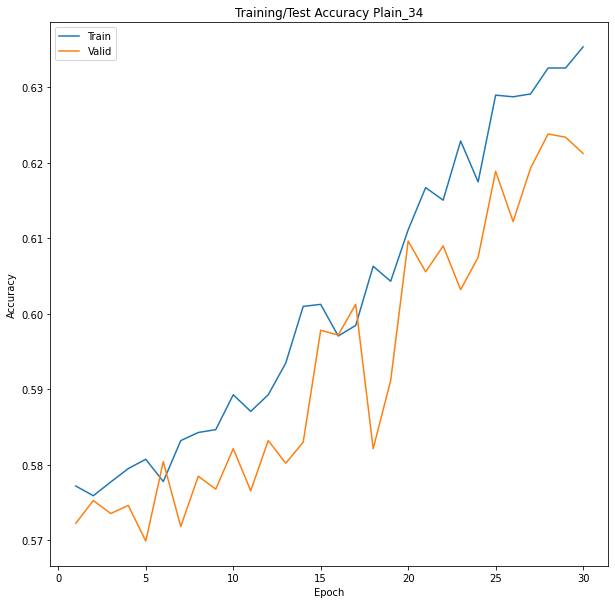

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy Plain_34")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_acc_list)+1), train_acc_list)
ax.plot(range(1, len(valid_acc_list)+1), valid_acc_list)
ax.legend(['Train', 'Valid'])
plt.show()

In [19]:
model = get_model('resnet34')
pbar = trange(30, desc='Valid Loss : 0', leave=True, position=0)
train_acc_list = []
train_loss_list = []
valid_acc_list = []
valid_loss_list = []

# start training
for epoch in pbar:
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    step = 0
    for images, labels in train_batches:
        step += 1
        train_step(images, labels)

    for valid_images, valid_labels in validation_batches:
        valid_step(valid_images, valid_labels)
    pbar.set_description("Valid Loss: %.3f" % valid_loss.result())

    train_acc_list.append(train_accuracy.result())
    train_loss_list.append(train_loss.result())
    valid_acc_list.append(valid_accuracy.result())
    valid_loss_list.append(valid_loss.result())

Model: "res_net_type_i_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_135 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 sequential_19 (Sequential)  (None, 56, 56, 64)        223104    
                                                                 
 sequential_20 (Sequential)  (None, 28, 28, 128)       1119872   
                                                                 
 sequential_22 (Sequential)  (None, 14, 14, 256)  

Valid Loss: 0.622: 100%|██████████| 30/30 [25:16<00:00, 50.56s/it]


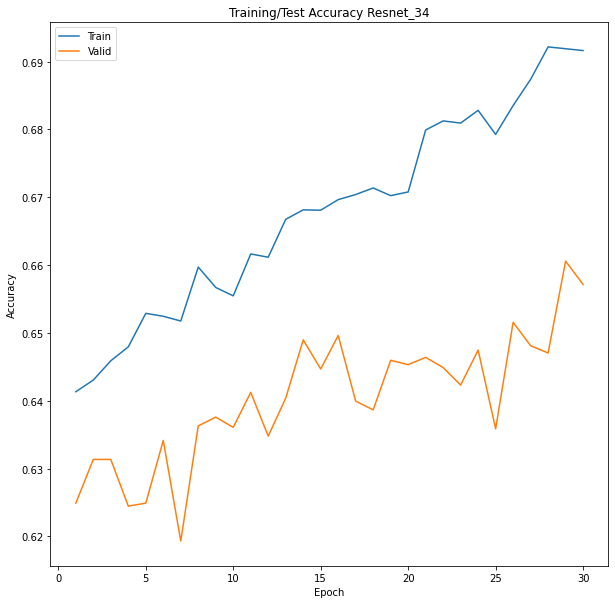

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy ResNet_34")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_acc_list)+1), train_acc_list)
ax.plot(range(1, len(valid_acc_list)+1), valid_acc_list)
ax.legend(['Train', 'Valid'])
plt.show()

In [21]:
model = get_model('resnet50_plain')
pbar = trange(30, desc='Valid Loss : 0', leave=True, position=0)
train_acc_list = []
train_loss_list = []
valid_acc_list = []
valid_loss_list = []

# start training
for epoch in pbar:
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    step = 0
    for images, labels in train_batches:
        step += 1
        train_step(images, labels)

    for valid_images, valid_labels in validation_batches:
        valid_step(valid_images, valid_labels)
    pbar.set_description("Valid Loss: %.3f" % valid_loss.result())

    train_acc_list.append(train_accuracy.result())
    train_loss_list.append(train_loss.result())
    valid_acc_list.append(valid_accuracy.result())
    valid_loss_list.append(valid_loss.result())

Model: "res_net_type_iv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_171 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_171 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 sequential_26 (Sequential)  (None, 56, 56, 64)        223104    
                                                                 
 sequential_27 (Sequential)  (None, 28, 28, 128)       1111040   
                                                                 
 sequential_28 (Sequential)  (None, 14, 14, 256)   

Valid Loss: 0.663: 100%|██████████| 30/30 [25:19<00:00, 50.64s/it]


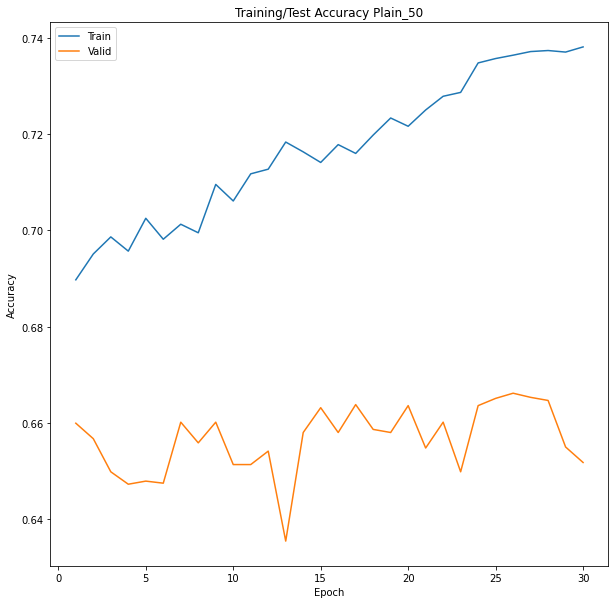

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy Plain_50")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_acc_list)+1), train_acc_list)
ax.plot(range(1, len(valid_acc_list)+1), valid_acc_list)
ax.legend(['Train', 'Valid'])
plt.show()

In [23]:
model = get_model('resnet50')
pbar = trange(30, desc='Valid Loss : 0', leave=True, position=0)
train_acc_list = []
train_loss_list = []
valid_acc_list = []
valid_loss_list = []

# start training
for epoch in pbar:
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    step = 0
    for images, labels in train_batches:
        step += 1
        train_step(images, labels)

    for valid_images, valid_labels in validation_batches:
        valid_step(valid_images, valid_labels)
    pbar.set_description("Valid Loss: %.3f" % valid_loss.result())

    train_acc_list.append(train_accuracy.result())
    train_loss_list.append(train_loss.result())
    valid_acc_list.append(valid_accuracy.result())
    valid_loss_list.append(valid_loss.result())

Model: "res_net_type_ii"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_204 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 sequential_30 (Sequential)  (None, 56, 56, 256)       353664    
                                                                 
 sequential_34 (Sequential)  (None, 28, 28, 512)       2024448   
                                                                 
 sequential_39 (Sequential)  (None, 14, 14, 1024)  

Valid Loss: 0.721: 100%|██████████| 30/30 [25:18<00:00, 50.63s/it]


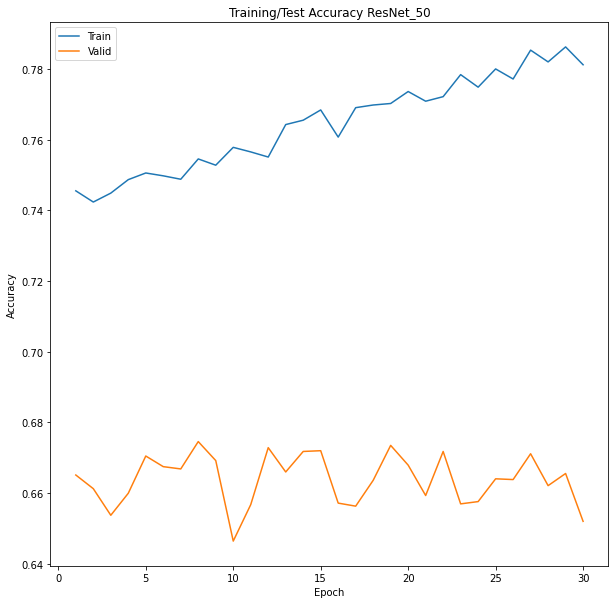

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy ResNet_50")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_acc_list)+1), train_acc_list)
ax.plot(range(1, len(valid_acc_list)+1), valid_acc_list)
ax.legend(['Train', 'Valid'])
plt.show()